In [2]:
import os
import io
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import log_loss, auc, roc_auc_score, precision_score, recall_score
from sklearn.cross_validation import train_test_split, KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


I have chosen two datasets from UCI Machine Learning Data Repository. I found Spambase dataset and Web phishing dataset as interesting ones, as I always <insert your story here>

In [58]:
# get header information of the data from UCI Machine Learning Repository
header_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names"
header_s = requests.get(header_url).content

#finding the index of the string where the column names start
index = header_s.find('word_freq_make')
header_s1 = header_s[index:]

#replace unwanted strings with empty space
strings_to_replace = [' ','continuous.\r\n']
for string in strings_to_replace:
    header_s1 = header_s1.replace(string,'')

#splitting the string to a list of column names
names = header_s1.split(':')

In [68]:
#list of columns
names;

In [108]:
# download the file from UCI Machine learning repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"   
s = requests.get(url).content
data = pd.read_csv(io.StringIO(s.decode('utf-8')), names = names, header = None)

In [109]:
# preview the data 
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [110]:
# From above, notice that the last columnname is blank; changing it to is_spam
data.rename(columns = {'':'is_spam'}, inplace = True)

In [111]:
#size of the data
data.shape

(4601, 58)

There are 4601 datapoints and 58 variables in the dataset

### Exploratory Data Analysis

Understanding the data and its quality

In [70]:
# quick glance at the type of variables and the number of non-null values in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
word_freq_make                4601 non-null float64
word_freq_address             4601 non-null float64
word_freq_all                 4601 non-null float64
word_freq_3d                  4601 non-null float64
word_freq_our                 4601 non-null float64
word_freq_over                4601 non-null float64
word_freq_remove              4601 non-null float64
word_freq_internet            4601 non-null float64
word_freq_order               4601 non-null float64
word_freq_mail                4601 non-null float64
word_freq_receive             4601 non-null float64
word_freq_will                4601 non-null float64
word_freq_people              4601 non-null float64
word_freq_report              4601 non-null float64
word_freq_addresses           4601 non-null float64
word_freq_free                4601 non-null float64
word_freq_business            4601 non-null float64
word_freq

The data looks complete and there are no categorical variables in this dataset; 

Incase, if there are any NA values, we need to either drop the NA data or impute the NA values with appropriate values depending on whether the data was missing on purpose or at random. Imputing the NA values with the mean/median of the column (incase of numeric) is a popular way. By using an algorithm like kNN regressor for numeric data or kNN classifier for categorical data may also be good method of imputation. 

In [66]:
#now let's look into the range of values for each of the columns
data.describe().T

,count,mean,std,min,25%,50%,75%,max
word_freq_make,4601.0,0.104553,0.305358,0.0,0.000,0.000,0.000,4.540
word_freq_address,4601.0,0.213015,1.290575,0.0,0.000,0.000,0.000,14.280
word_freq_all,4601.0,0.280656,0.504143,0.0,0.000,0.000,0.420,5.100
word_freq_3d,4601.0,0.065425,1.395151,0.0,0.000,0.000,0.000,42.810
word_freq_our,4601.0,0.312223,0.672513,0.0,0.000,0.000,0.380,10.000
word_freq_over,4601.0,0.095901,0.273824,0.0,0.000,0.000,0.000,5.880
word_freq_remove,4601.0,0.114208,0.391441,0.0,0.000,0.000,0.000,7.270
word_freq_internet,4601.0,0.105295,0.401071,0.0,0.000,0.000,0.000,11.110
word_freq_order,4601.0,0.090067,0.278616,0.0,0.000,0.000,0.000,5.260
word_freq_mail,4601.0,0.239413,0.644755,0.0,0.000,0.000,0.160,18.180


The dataset is majorly composed of character/word frequencies and the format of the text. Since, frequency can only be greater than or equal to 0 any column with less than 0 value doesn't make any sense (is not acceptable). From 'min' column in the above dataframe, we can see that the data looks valid, hence forth we can proceed further in our analysis.

There are 58 variables altogether in this dataset; 'is_spam' is the dependent variable and the other 57 are independent variables

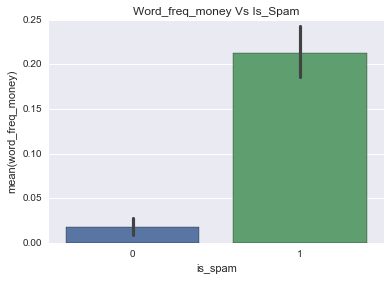

In [74]:
#let us look into correlation between some interesting variables
sns.barplot(y ='word_freq_money', x = 'is_spam', data = data)
plt.title('Word_freq_money Vs Is_Spam')

When ever the emails are with high word_freq_money it is leading to spam

### Data Preparation

-- Write about AUC metric, why we are using this and how to interpret it

In [112]:
# separating the response and predictor variables

y = data.pop('is_spam') # response variable
X = data # predictor variables

In [116]:
predictor_cols = X.columns

Splitting the data into train and test datasets helps us in evaluating our model. We create a model based on only training data (train dataset) and we later predict the values for test data which were never seen before by the model. With this, we can evaluate how robust our model is for new data. Ideally 70:30 (train:test) is the ratio used to make a split on the dataset.

In [113]:
# we have used an input parameter 'random_state', which is assigned with some arbitary number to ensure that, when 
# ever the code is rerun it would produce the same train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

### k-Nearest Neighbors

-- description about working of this algorithm

It is an instance based learning algorithm which does not require to train the model prior inorder to predict the output of new input data. As the name suggests, we will predict the response value by finding the 'k' nearest neighbors which are obtained by calculating the distance between data points. 'k' should be an odd number, in a classification problem the predicted output is based on the class with majority datapoint surronded around this data.

Training phase is fast (i.e. only saving of the data). Predictions are made very slow as it needs to calulate the distance between the input datapoint and all other datapoints in the dataset. As the number of data points (n) increases the time taken to predict also increases. And also, if the number of predictor variables are too many it may lead to curse of dimensionality issue where the data becomes sparse in a high dimensional space.

- talk about different distance metrics in knn

-- write about why we need to standardize/normalize the data before modelling where distance related metrics are involved

In [121]:
#before preprocessing 
pd.DataFrame(X, columns = predictor_cols).ix[:,:5].describe().ix[[1,2,5,7]]

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our
mean,0.104553,0.213015,0.280656,0.065425,0.312223
std,0.305358,1.290575,0.504143,1.395151,0.672513
50%,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000


In [114]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(X_scaled, y,\
                                                                                test_size=0.3,\
                                                                                random_state=10)

In [122]:
#after preprocessing
pd.DataFrame(X_scaled, columns = predictor_cols).ix[:,:5].describe().ix[[1,2,5,7]]

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our
mean,4.844708e-15,-9.171827e-16,-4.647855e-15,-2.025297e-15,4.101503e-16
std,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00
50%,-3.424337e-01,-1.650719e-01,-5.567606e-01,-4.689958e-02,-4.643144e-01
max,1.452700e+01,1.090096e+01,9.560519e+00,3.064128e+01,1.440691e+01


We can see the data is standardized where the mean ~0 and the std is ~ 1

In [123]:
# size of training set
X_scaled_train.shape

(3220, 57)

In [124]:
# size of test set
X_scaled_test.shape

(1381, 57)

In [153]:
k_vals = range(3, 13, 2)
kauc_trn, kauc_tst = np.zeros(len(k_vals)), np.zeros(len(k_vals))

for i, k in zip(range(0, len(k_vals)), k_vals):
    
    # euclidean distance
    clf = KNeighborsClassifier(n_neighbors=k, metric='minkowski', weights='uniform', p = 2) 
    clf = clf.fit(X_scaled_train, y_scaled_train)
    pred_tst = clf.predict_proba(X_scaled_test)[:,1]
    pred_trn = clf.predict_proba(X_scaled_train)[:,1]
    kauc_tst[i] = roc_auc_score(y_scaled_test, pred_tst)
    kauc_trn[i] = roc_auc_score(y_scaled_train, pred_trn)
    

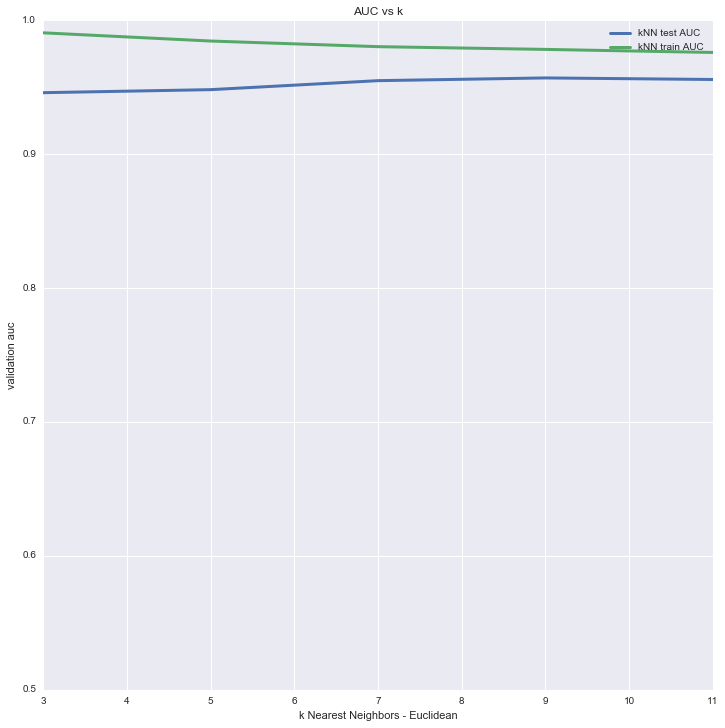

In [154]:
plt.figure(figsize=(12,12))
plt.plot(k_vals, kauc_tst, linewidth=3, label = "kNN test AUC")
plt.plot(k_vals, kauc_trn, linewidth=3, label = "kNN train AUC")
plt.legend()
plt.ylim(0.5, 1.0)
plt.xlabel("k Nearest Neighbors - Euclidean")
plt.ylabel("validation auc")
plt.title('AUC vs k')

In [155]:
print "Best test set auc is %0.3f" % kauc_tst.max(), "for %0.0f neighbors" % list(range(10,71,10))[kauc_tst.argmax()]

Best test set auc is 0.957 for 40 neighbors


### SVM

In [ ]:
parameters = {'C':[0.0001,0.005,0.01, 0.1, 1, 10, 100, 1000]}
est = SVC(kernel="linear")
clf = GridSearchCV(est, parameters, cv=10)
clf.fit(X, y)